In [1]:
import numpy as np
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from tqdm import tqdm

In [88]:
# constants
Tmax = 5
c = 0.1
sigma_0 = 0.01
torque = 1
torque_c = 0.1
m = 1
l = 1
g_earth = 9.8
mu = 0.01
timestamp = 500
delta_t = 20 / timestamp
num_trials = 100

In [3]:
def g(x): # input x doesn't mean state, just a random input
    return 2/np.pi * (np.arctan(np.pi * x / 2))

In [4]:
def g_inv(x): # input x doesn't mean state, just a random input
    return (2 * math.tan(np.pi * x / 2)) / np.pi

In [5]:
def G(x): # input x doesn't mean state, just a random input
    return c * (-4 * np.log(math.cos(np.pi * (x/Tmax) / 2)) / (np.pi ** 2))

In [106]:
def f(x, u):
    return np.array([x[1], -mu * x[1] + g_earth * np.sin(x[0]) + u])

In [6]:
def reward(x, T):
    return np.cos(x[0]) - G(T)

In [62]:
def gaussian(x, num_gaussians=12):
    x1_centers = np.linspace(-np.pi, np.pi, num_gaussians)
    x2_centers = np.linspace(-10, 10, num_gaussians)
    sigma = 0.1

    first = (x[0] - x1_centers) ** 2
    second = (x[1] - x2_centers) ** 2
    norm = (first[:, np.newaxis] + second).flatten()
    basis_functions = np.exp(-norm / (2 * sigma ** 2))

    return basis_functions

# basis_functions = gaussian(init_data[0])

In [34]:
def grad_gaussian(x, num_gaussians=12):
    x1_centers = np.linspace(-np.pi, np.pi, num_gaussians)
    x2_centers = np.linspace(-10, 10, num_gaussians)
    sigma = 0.1
    coef1 = np.zeros(num_gaussians ** 2)
    coef2 = np.zeros(num_gaussians ** 2)
    
    for i in range(num_gaussians):
        coef1[12 * i:(12 * i + 11)] = -(x[0] - x1_centers[i]) / (sigma ** 2)
        coef2[12 * i:(12 * i + 11)] = -(x[1] - x2_centers[i]) / (sigma ** 2)
        
    return coef1, coef2

In [35]:
def calc_error(x, prev_x, weight, T):
    if prev_x is not None:
        pred = np.dot(weight, gaussian(x))
        prev_pred = np.dot(weight, gaussian(prev_x))
        return reward(x, T) + 0.4/delta_t * ((1 - delta_t/0.4) * pred - prev_pred)
    else:
        return 0

In [68]:
# simulate the dynamics: m*l*theta_double_dot = -mu*theta_dot + m*g*l*sin(theta) + T
def pendulum_dynamics(y, t, T):
    theta, theta_dot = y
    theta_double_dot = -0.01 * theta_dot + 9.8 * np.sin(theta) + T
    return [theta_dot, theta_double_dot]

# generate 500 data with 500 initial T
def gen_data(control):
    time = np.linspace(0, 20, timestamp)

    # Initial conditions
    theta_0 = 0 # np.random.uniform(0, 2 * np.pi)
    theta_dot_0 = 0
    theta = np.zeros(timestamp)
    theta_dot = np.zeros(timestamp)

    for i, t in enumerate(time):
        T = control[i]
        y = odeint(pendulum_dynamics, [theta_0, theta_dot_0], [0, delta_t], args=(T,))
        # Extract the theta value from the solution
        theta[i] = y[-1, 0] % (2 * np.pi)
        theta_dot[i] = y[-1, 1]
        # Update the initial conditions for the next time step
        theta_0 = y[-1, 0]
        theta_dot_0 = y[-1, 1]
    
    data = np.column_stack((theta, theta_dot))
    return data

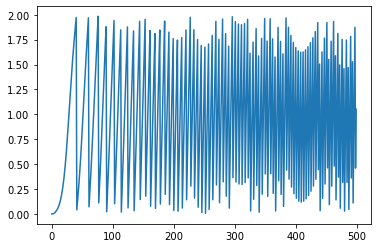

In [10]:
# init policy
T0 = np.random.uniform(0, Tmax, timestamp)
init_data = gen_data(T0)
init_theta = [x[0]/np.pi for x in init_data]
plt.plot(init_theta);

## 5.0 No Optimization

____________________________________________________________________________________________

In [116]:
tol = 1e-5
alpha = 0.01

def pred_weight_learning(data, weight, T):
    prev_state = None
    final_weight = None
    t_up = 0
    preds = []
    errors = []

    for i in range(timestamp):
        state = data[i]
        pred = np.dot(weight, gaussian(state))
        preds.append(pred)
        
        error = calc_error(state, prev_state, weight, T[i])
        err_sum = error_sum(data, weight, T)
        errors.append(err_sum)
        
        if prev_state is not None:
            delta_v = alpha * error * gaussian(prev_state)
#             delta_v = -alpha * (reward(state, T[i]) - pred + 0.4 * np.dot(weight, np.matmul(f(state, T[i]), grad_gaussian(state))))\
#                         * (-gaussian(state) + 0.4 * np.matmul(f(state, T[i]), grad_gaussian(state)))
            weight += delta_v
        
        prev_state = state
        
        if (prev_state[0] < np.pi / 2) or (prev_state[0] > 1.5 * np.pi):
            t_up = t_up + 1
            
        if i == timestamp - 1:
            final_weight = weight
            
    return preds, t_up, final_weight, errors

In [12]:
def error_sum(data, weight, T):
    err_sum = 0
    prev_state = None
    for i in range(timestamp):
        state = data[i]
        error = calc_error(state, prev_state, weight, T[i])
        prev_state = state
        err_sum += abs(error)
    return err_sum

## 5.1 Optimal Control

In [63]:
def prediction_derivative(weights, x, sigma=0.1):
    gaussian_values = gaussian(x)
    grad_gaussian_values = grad_gaussian(x)
    grad_coef_x1, grad_coef_x2 = grad_gaussian_values[0], grad_gaussian_values[1]
    derivatives_x1 = np.dot(weights * grad_coef_x1, gaussian_values)
    derivatives_x2 = np.dot(weights * grad_coef_x2, gaussian_values)
    return derivatives_x1, derivatives_x2

In [14]:
def optimal_control_learning(weights, x):
    b = np.array([0.0, 1.0])
    noise = np.random.normal(0, 1, 1)[0]
    pred = np.dot(weights, gaussian(x))
    g_val = g(Tmax / c * torque * np.dot(b, prediction_derivative(weights, x)) + sigma_0 * np.exp(-pred) * noise)
    return Tmax * g_val

____________________________________________________________________________________________

In [117]:
T = T0
t_ups = np.array([])
errs = [0] * 100
init_weight = np.ones(12 ** 2)
w = init_weight

for i in tqdm(range(50)):
    data = gen_data(T)
    learning = pred_weight_learning(data, w, T)
    
    t_up = learning[1]
    final_weight = learning[2]
    err_sum = error_sum(data, final_weight, T)
    errs[i] = err_sum / timestamp

    t_ups = np.append(t_ups, t_up * 20 / timestamp)
    optimal_control = np.array([optimal_control_learning(final_weight, data[i]) for i in range(timestamp)])
    T = optimal_control
    w = final_weight

  0%|          | 0/50 [00:04<?, ?it/s]


KeyboardInterrupt: 

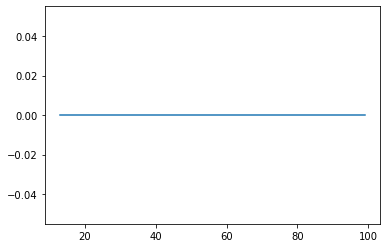

In [109]:
plt.plot(errs);

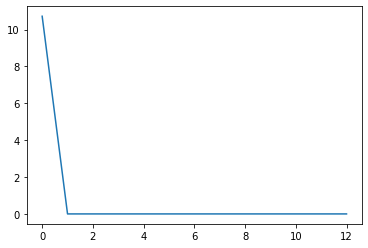

In [110]:
plt.plot(t_ups);

## 5.2 Actor-Critic

In [27]:
tol = 1e-5
alpha = 0.01

def critic_weight_learning(data, weight, T):
    prev_state = None
    preds = np.array([])
    errors = []
    final_weight = None
    t_up = 0

    for i in range(timestamp):
        state = data[i]
        pred = np.dot(weight, gaussian(state))
        preds = np.append(preds, pred)

        error = calc_error(state, prev_state, weight, T[i])
        err_sum = error_sum(data, weight, T)
        errors.append(err_sum)        

        if prev_state is not None:
            noise = np.random.normal(0, 1, 1)[0]
            delta_v = alpha * error * noise * gaussian(prev_state)
            weight += delta_v

        prev_state = state

        if i == timestamp - 1:
            final_weight = weight
            
        if (prev_state[0] < np.pi / 2) or (prev_state[0] > 1.5 * np.pi):
            t_up = t_up + 1

    return final_weight, preds, t_up

In [28]:
def critic_control_learning(data, w):
    opts = np.array([])
    for i in range(timestamp):
        noise = np.random.normal(0, 1, 1)[0]
        g_val = g(np.dot(w, gaussian(data[i])) + sigma_0 * np.exp(-np.dot(w, gaussian(data[i]))) * noise)
        opts = np.append(opts, Tmax * g_val)
    return opts

____________________________________________________________________________________________

In [118]:
T = T0
t_ups = np.array([])
errs = [0] * 100
init_weight1 = np.ones(12)
w = init_weight

for i in tqdm(range(10)):
    data = gen_data(T)
    learning = critic_weight_learning(data, w, T)
    t_up = learning[2]
    t_ups = np.append(t_ups, t_up * 20 / timestamp)
    
    final_weight = learning[0]
    err_sum = error_sum(data, final_weight, T)
    errs[i] = err_sum / timestamp
    
    T = critic_control_learning(data, final_weight)
    w = final_weight

100%|██████████| 10/10 [02:09<00:00, 12.98s/it]


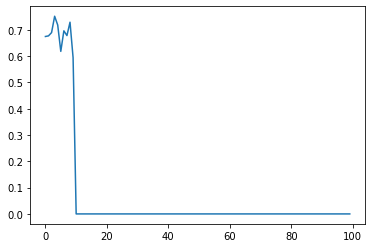

In [31]:
plt.plot(errs);

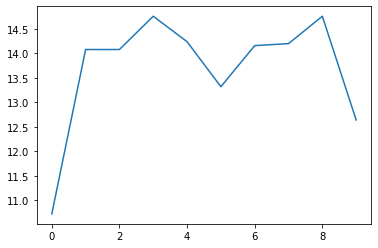

In [32]:
plt.plot(t_ups);